# CBB Ranking Adjusted by 3 pt Shooting

This is the general outline for this ranking:

* One parameter per team tracking the following quantities:
  * Adjusted offensive efficiency
  * Adjusted defensive efficiency
  * 3 point shooting percentage
  * Tempo
* Inputs
  * Raw offensive efficiency
  * Raw defensive efficiency
  * 3 point shots taken and made
* General structure of the code
  * Set team-length vectors `oeff`, `deff`, `3pct`, and `tempo`
  * Data views each game from POV of winning team
  * Iterate through each game, creating a new `adj_oeff` and `adj_deff` that is a "what if" based on that team shooting their average from three. These "what-ifs" use the `3pct` vectors.
  * Iterate through each game again, modeling the `adj_oeff` and `adj_deff`  based on the `oeff`, `deff`, and an error term.
  * Model 3pm given 3pa as a binomial using `3pct`


In [1]:
import pandas as pd 
import numpy as np
import pystan
import matplotlib.pyplot as plt
import arviz
import seaborn as sns

from pyprojroot import here

INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


In [126]:
games = pd.read_csv(here("data/acc_games_2018.csv"), parse_dates=['date_game'])
teams = pd.read_csv(here("data/acc_teams_2018.csv"))
games.head()

,efficiency_i,efficiency_j,fg3_i,fg3_j,fg3a_i,fg3a_j,home_i,date_game,year,avg_possessions,game_id,gos_i,gos_j,team_i,team_j
0,1.184141,1.117616,15.0,8.0,26.0,30.0,1,2017-12-09,2018,75.16,41590,9.0,11.0,1,3
1,0.946119,0.930083,9.0,7.0,23.0,22.0,1,2017-12-30,2018,62.36,41594,12.0,13.0,13,1
2,1.069055,1.011268,8.0,9.0,23.0,21.0,-1,2018-01-03,2018,69.22,41595,13.0,14.0,2,1
3,0.974684,0.898734,7.0,12.0,22.0,26.0,1,2018-01-06,2018,79.00,41596,15.0,14.0,1,15
4,1.425601,0.980101,9.0,12.0,27.0,33.0,1,2018-01-09,2018,67.34,41597,16.0,16.0,8,1


In [101]:
cutoff = pd.to_datetime("2018-02-15")
train = games[games['date_game'] < cutoff]
test = games[games['date_game'] >= cutoff]
print(train.shape)
print(test.shape)

(100, 15)
(50, 15)


<AxesSubplot:xlabel='avg_possessions'>

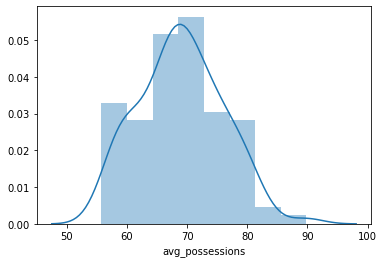

In [9]:
sns.distplot(train['avg_possessions'])
# sns.distplot(train['efficiency_j'])

In [5]:
model_code = """
data {
    // train values
    int<lower=0> k;
    int<lower=0> n;
    int h[n];
    int team_i[n];
    int team_j[n];
    vector[n] raw_eff_i;
    vector[n] raw_eff_j;
    vector[n] possessions;
    
    // test values
    int<lower=0> n_test;
    int h_test[n_test];
    int team_i_test[n_test];
    int team_j_test[n_test];    
}
parameters {
    vector[k] oeff;
    vector[k] deff;
    vector[k] tempo;
    real<lower=0> sigma;
    real<lower=0> tau_eff;
    real<lower=0> sigma_tempo;    
    real<lower=0> tau_tempo;    
}
transformed parameters {

}
model {
    // variances
    sigma ~ cauchy(0, 0.25);
    tau_eff ~ cauchy(0, 0.25);
    sigma_tempo ~ cauchy(0, 5);
    tau_tempo ~ cauchy(0, 5);

    // Team specific parameters
    oeff ~ normal(1, tau_eff);
    deff ~ normal(1, tau_eff);
    tempo ~ normal(70, tau_tempo);

    // Model data
    for (t in 1:n) {
        raw_eff_i[t] ~ normal((oeff[team_i[t]] + deff[team_j[t]]) / 2, sigma);
        raw_eff_j[t] ~ normal((oeff[team_j[t]] + deff[team_i[t]]) / 2, sigma);
        possessions[t] ~ normal((tempo[team_i[t]] + tempo[team_j[t]]) / 2, sigma_tempo);
    }
}
generated quantities {
    // Declare vectors
    vector[n_test] scores_i;
    vector[n_test] scores_j;
    vector[n_test] test_possessions;

    // Simulate games
    for (t in 1:n_test) {
        test_possessions[t] = normal_rng((tempo[team_i_test[t]] + tempo[team_j_test[t]]) / 2, sigma_tempo);
        scores_i[t] = test_possessions[t] * normal_rng((oeff[team_i_test[t]] + deff[team_j_test[t]]) / 2, sigma);
        scores_j[t] = test_possessions[t] * normal_rng((oeff[team_j_test[t]] + deff[team_i_test[t]]) / 2, sigma);
    }
}
"""

sm = pystan.StanModel(model_code=model_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6be6a3c84e829d79b25adb72813ddaa NOW.


In [10]:
dat = {
    'k': len(np.union1d(train['team_i'].unique(), train['team_j'].unique())),
    'n': len(train),
    'h': train['home_i'],
    'team_i': train['team_i'],
    'team_j': train['team_j'],
    'raw_eff_i': train['efficiency_i'],
    'raw_eff_j': train['efficiency_j'],
    'possessions': train['avg_possessions'],
    'n_test': len(test),
    'h_test': test['home_i'],
    'team_i_test': test['team_i'],
    'team_j_test': test['team_j']
}

fit = sm.sampling(data=dat, warmup=500, iter=2500, chains=2, refresh=100)


array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'tau_eff'}>,
        <AxesSubplot:title={'center':'tau_eff'}>],
       [<AxesSubplot:title={'center':'sigma_tempo'}>,
        <AxesSubplot:title={'center':'sigma_tempo'}>],
       [<AxesSubplot:title={'center':'tau_tempo'}>,
        <AxesSubplot:title={'center':'tau_tempo'}>]], dtype=object)

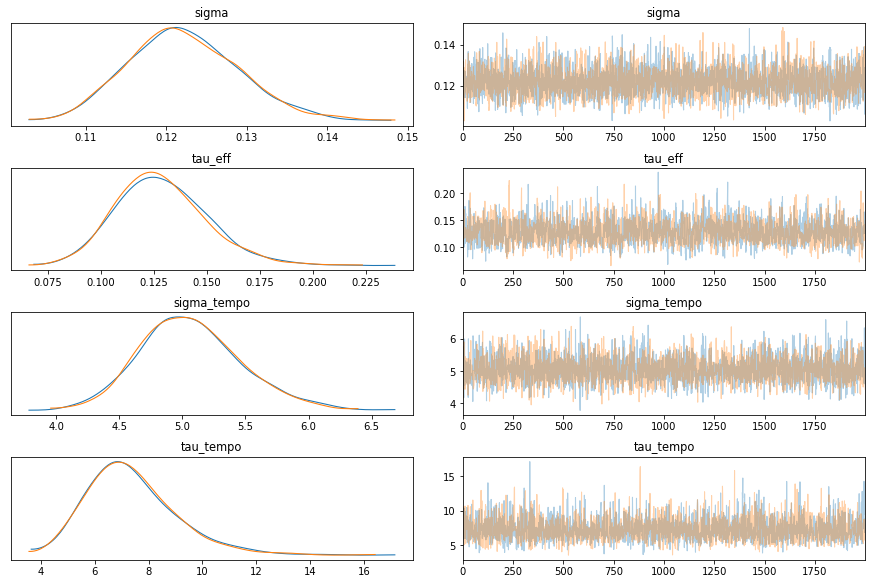

In [21]:
arviz.plot_trace(fit, var_names=['sigma', 'tau_eff', 'sigma_tempo', 'tau_tempo'])

In [20]:
teams

,team_id,team_name
0,1,boston-college
1,2,clemson
2,3,duke
3,4,florida-state
4,5,georgia-tech
5,6,louisville
6,7,miami-fl
7,8,north-carolina
8,9,north-carolina-state
9,10,notre-dame


In [22]:
df = fit.to_dataframe()

In [23]:
df.head()

,chain,draw,warmup,oeff[1],oeff[2],oeff[3],oeff[4],oeff[5],oeff[6],oeff[7],...,test_possessions[48],test_possessions[49],test_possessions[50],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,1.136734,1.098336,1.184216,1.175616,0.842422,1.099620,0.952556,...,62.850844,54.539269,58.406681,121.339473,0.885881,0.450237,3,7,0,-95.286205
1,0,1,0,1.029930,1.062439,1.235163,1.070787,0.940041,1.204299,1.083794,...,55.256742,56.173145,72.409107,124.422855,0.836695,0.450237,3,7,0,-101.764691
2,0,2,0,1.033789,1.005285,1.223903,1.035367,0.865490,1.005355,1.026318,...,66.459442,54.839771,62.579755,120.981275,0.896354,0.450237,3,7,0,-103.226347
3,0,3,0,1.091585,0.934475,1.205579,1.160129,0.904227,1.051947,1.033693,...,62.526911,57.103493,66.897542,120.463008,0.952102,0.450237,3,7,0,-102.069247
4,0,4,0,1.086409,0.890569,1.194781,1.125787,0.880464,1.035796,1.038592,...,69.148074,60.304128,67.681352,117.676894,0.798816,0.450237,3,15,0,-92.197884


## Extract Team-specific measures


In [86]:
def extract_from_stan(df, add_cols, quantiles, measures):
    keep_cols = [col for col in df.columns for add_col in add_cols if (add_col in col) & ('[' in col)]
    df = df[keep_cols].copy()
    temp_list = [col.split('[') for col in df.columns]
    
    measure_cols = []
    num_cols = []
    for col in df.columns:
        i, j = col.split('[')
        measure_cols.append(i)
        num_cols.append(int(j[:-1]))

    hierarchical_index = zip(measure_cols, num_cols)
    df.columns = pd.MultiIndex.from_tuples(hierarchical_index, names=['measure', 'num'])
    df_agg = pd.concat([df.quantile(quantiles), df.agg(measures)])
    df_agg = df_agg.T.reset_index()
    df_agg = pd.pivot_table(df_agg, columns=['measure'], index='num', values=quantiles + measures)
    df_agg.columns = [f"{j}_{i}" for i, j in df_agg.columns]
    df_agg = df_agg.sort_index(axis=1).reset_index()

    return df_agg


In [88]:
# Define quantities to extract
add_cols = ['oeff', 'deff', 'tempo']
quantiles = [0.025, 0.5, 0.975]
other_measures = ['mean']

# Extract quantities and measures
df = fit.to_dataframe()
team_data = teams.copy()
df_agg = extract_from_stan(df, add_cols, quantiles, other_measures)
df_agg = df_agg.rename(columns={'num': 'team_id'})

# Merge with team names
team_data = team_data.merge(df_agg, on='team_id', how='left')

<AxesSubplot:ylabel='team_name'>

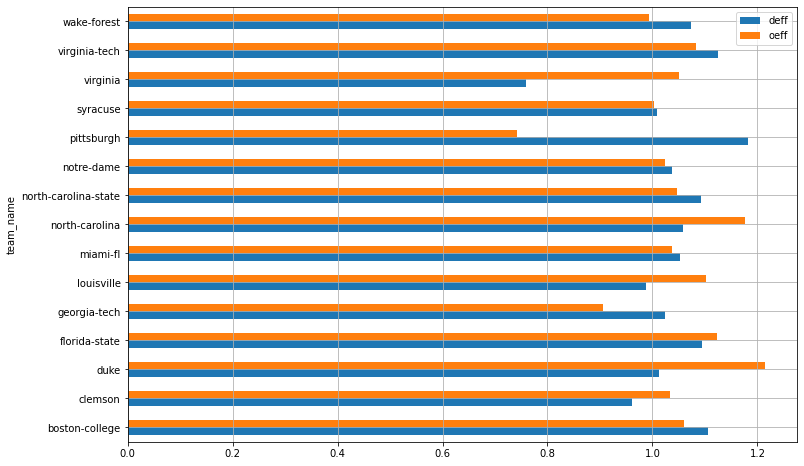

In [89]:
# Plot Measures for sanity
temp_df = team_data.set_index('team_name')
val = 'mean'
measures = ['oeff','deff']
cols = [col for col in temp_df.columns for meas in measures if (val in col) and (meas in col)]
temp_df = temp_df[cols].rename(columns={col: col.split('_')[0] for col in cols})
temp_df.plot.barh(figsize=(12, 8), grid=True)

## Extract Test Game results

In [111]:
# Define quantities to extract
add_cols = ['test_possessions', 'scores_i', 'scores_j']
quantiles = [0.025, 0.5, 0.975]
other_measures = ['mean']

# Extract and merge
df_agg = extract_from_stan(df, add_cols, quantiles, other_measures)
df_test = pd.concat([test.reset_index(drop=True), df_agg.drop('num', axis=1)], axis=1)

# Add in the actual scores
for val in ['i', 'j']:
    df_test[f'act_score_{val}'] = (df_test[f'efficiency_{val}'] * df_test['avg_possessions']).round().astype(int)

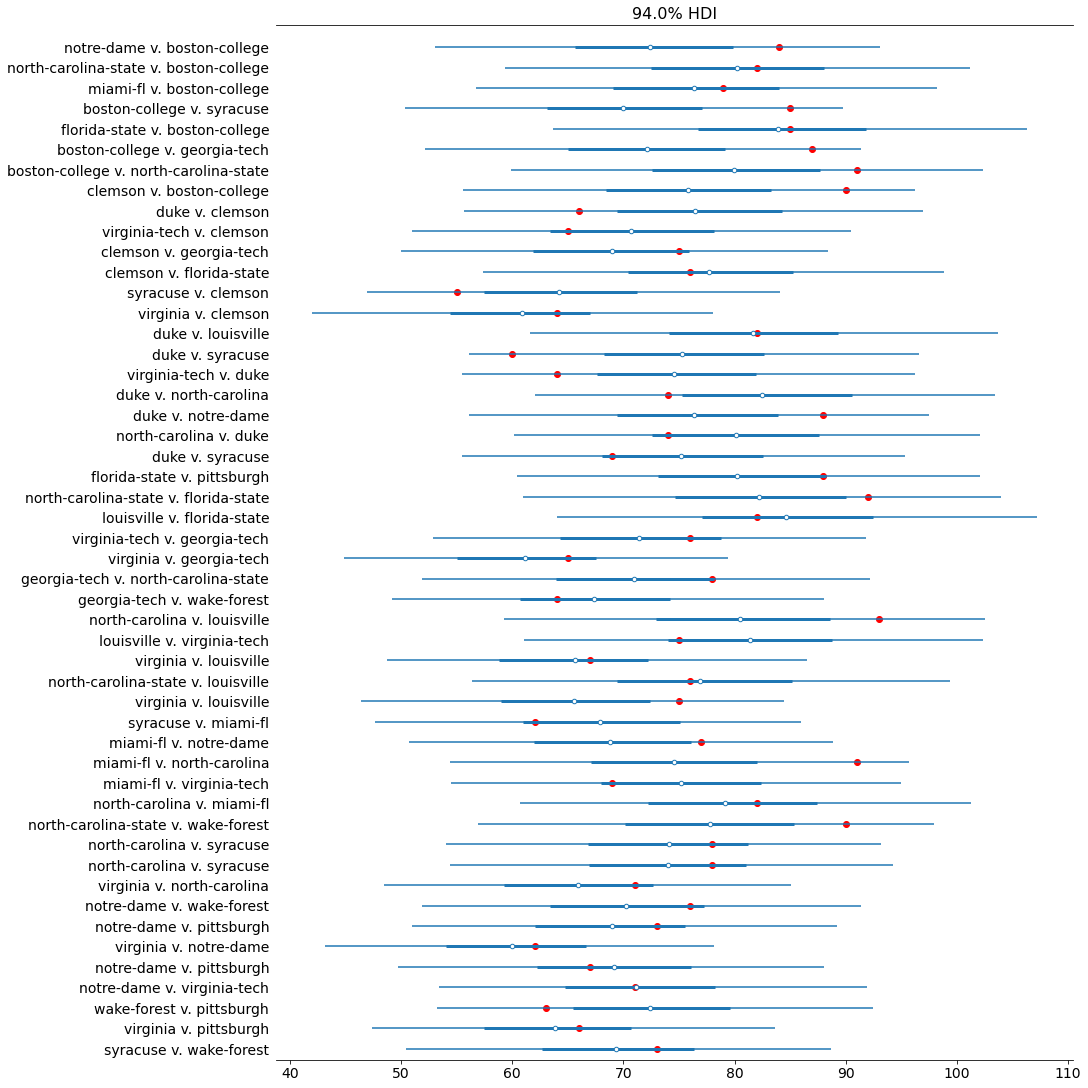

In [128]:
val = 'i'
axes=arviz.plot_forest(fit, var_names=[f'scores_{val}'], combined=True, figsize=(15, 15))
# axes[0].axvline(0, c='black', ls=':')
y_vals = axes[0].get_yticks()
x_vals = np.flip(df_test[f'act_score_{val}']).values
team_is = teams.set_index('team_id').loc[df_test['team_i'], 'team_name'].tolist()
team_js = teams.set_index('team_id').loc[df_test['team_j'], 'team_name'].tolist()
team_labels = np.flip([' v. '.join(t) for t in zip(team_is, team_js)])
axes[0].scatter(x_vals, y_vals, c='red')
axes[0].set_yticklabels(team_labels)
plt.show()




## TODO

* [x] Clean box score data to be input to Stan predictions
* [x] Implement basic efficiency system and verify it works
* [ ] Create visuals that show predictions on score for both teams compared to actual
* [ ] Set up evaluation according to the pinball metric and accuracy of who won
* [ ] Implement with 3 pt shooting